In [9]:
import jax
import jax.numpy as jnp

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder


In [10]:
X,y=load_iris(return_X_y=True)
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42)

scaler=StandardScaler()
one_hot_encoder=OneHotEncoder(sparse_output=False)

X_train,y_train=scaler.fit_transform(X_train),one_hot_encoder.fit_transform(y_train.reshape(-1,1))
X_test,y_test=scaler.transform(X_test),one_hot_encoder.transform(y_test.reshape(-1,1))



print((X_train.shape,y_train.shape),(X_test.shape,y_test.shape))

((112, 4), (112, 3)) ((38, 4), (38, 3))


In [11]:
X_train,y_train=jnp.array(X_train),jnp.array(y_train)
X_test,y_test=jnp.array(X_test),jnp.array(y_test)

In [12]:
from contextlib import contextmanager
from typing import Callable, Sequence
import flax.linen as nn



class CustomDense(nn.Module):
    features:int
    activation:Callable=nn.relu
    dropout:float=0.3

    def setup(self):
        self.dense=[
            nn.Dense(self.features),
            nn.Dropout(self.dropout),
            self.activation,
            nn.BatchNorm()
        ]


    def __call__(self,x,training=False):
       for layer in self.dense:
            if isinstance(layer,nn.BatchNorm):
               x=layer(x,use_running_average=not training)
            elif isinstance(layer,nn.Dropout):
                x=layer(x,deterministic=not training) 
            else:
                x=layer(x)
            return x


class MLP(nn.Module):
    layer_sizes:Sequence[int]
    activation:Callable=nn.relu

    def setup(self):
        __layers=[CustomDense(features) for features in self.layer_sizes[:-1]]
        __layers.append(nn.Dense(self.layer_sizes[-1]))

        self.mlp=__layers

    def __call__(self,x,training=False):
        for layer in self.mlp:
            if isinstance(layer,CustomDense):
                x=layer(x,training=training)
            else:
                x=layer(x)
        return x

In [13]:
mlp=MLP([16,16,3])
mlp

MLP(
    # attributes
    layer_sizes = [16, 16, 3]
    activation = relu
)

In [14]:
variables=mlp.init(jax.random.PRNGKey(42),X_train[:32])
variables

{'params': {'mlp_0': {'dense_0': {'kernel': Array([[-0.2500764 ,  0.321198  , -0.43895745, -0.18518311,  0.82215154,
            -0.40394294,  0.02157013, -0.5264202 ,  0.6462952 ,  0.10710552,
            -1.0247616 , -0.1418568 , -0.81232756, -0.70297426, -0.18576325,
             0.14239244],
           [-0.9592025 , -0.40239382, -0.3990191 , -0.1311315 ,  0.65223044,
             0.07760987, -0.01750862, -0.04786694, -0.17399241,  0.92125714,
             0.47253236,  0.79109526,  0.22479118,  0.9483041 ,  0.19801874,
            -0.39667287],
           [ 0.4215961 , -0.06598052, -0.20873363, -0.09556825,  1.0956135 ,
             0.23875721,  0.5886765 , -0.15583332,  0.83828825, -0.21923168,
             0.5203881 , -0.13622479, -0.3613821 , -0.0828403 ,  0.23255756,
            -0.9218056 ],
           [ 0.4813464 , -0.62470704,  0.770763  , -0.38405102,  0.5112657 ,
             0.25096774, -0.31449082, -0.10360464,  1.1194936 ,  0.09932385,
             0.09045017,  0.6672008

In [15]:
params=variables['params']

In [16]:
print(jax.tree.map(lambda x:x.shape,variables))

{'params': {'mlp_0': {'dense_0': {'bias': (16,), 'kernel': (4, 16)}}, 'mlp_1': {'dense_0': {'bias': (16,), 'kernel': (16, 16)}}, 'mlp_2': {'bias': (3,), 'kernel': (16, 3)}}}


In [17]:
print(mlp.tabulate(jax.random.key(0),X_train[:32]))


                                  MLP Summary                                  
┌───────────────┬─────────────┬───────────────┬───────────────┬───────────────┐
│ path          │ module      │ inputs        │ outputs       │ params        │
├───────────────┼─────────────┼───────────────┼───────────────┼───────────────┤
│               │ MLP         │ float32[32,4] │ float32[32,3] │               │
├───────────────┼─────────────┼───────────────┼───────────────┼───────────────┤
│ mlp_0         │ CustomDense │ -             │ float32[32,1… │               │
│               │             │ float32[32,4] │               │               │
│               │             │ - training:   │               │               │
│               │             │ False         │               │               │
├───────────────┼─────────────┼───────────────┼───────────────┼───────────────┤
│ mlp_0/dense_0 │ Dense       │ float32[32,4] │ float32[32,1… │ bias:         │
│               │             │        

In [18]:
from optax import sgd,softmax_cross_entropy
from flax.training import train_state

state=train_state.TrainState.create(
    apply_fn=mlp.apply,
    params=params,
    tx=sgd(0.03),
)


# @jax.jit
def calculate_loss_and_acc(state:train_state.TrainState,params,x:jax.Array,y:jax.Array,training:bool)->tuple[jnp.ndarray,jnp.ndarray]:
    logits=state.apply_fn({"params":params},x,training=training)
    loss=softmax_cross_entropy(logits,y).mean()
    accuracy=jnp.mean(jnp.argmax(logits,-1)==jnp.argmax(y,-1))
    return loss,accuracy

@jax.jit
def train_step(state:train_state.TrainState,x:jax.Array,y:jax.Array)->tuple[train_state.TrainState,jnp.ndarray,jnp.ndarray]:
    # grad-fn
    grad_fn=jax.value_and_grad(calculate_loss_and_acc,has_aux=True,argnums=1)

    (loss,accuracy),grads=grad_fn(state,state.params,x,y,training=True)
    state=state.apply_gradients(grads=grads)
    return state,loss,accuracy

@jax.jit
def valid_step(state:train_state.TrainState,x:jax.Array,y:jax.Array)->tuple[jnp.ndarray,jnp.ndarray]:
    loss,accuracy=calculate_loss_and_acc(state,state.params,x,y,training=False)
    return loss,accuracy

In [19]:
import math


EPOCHS=75
BATCH_SIZE=32

history={'train_loss':[],'val_loss':[],'train_accuracy':[],'val_accuracy':[]}
for epoch in range(EPOCHS):
    n=math.ceil(X_train.shape[0]/BATCH_SIZE)
    _loss,_accuracy=0.0,0.0
    for i in range(n):
        x=X_train[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
        y=y_train[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
        state,loss,accuracy=train_step(state,x,y)
        _loss+=loss
        _accuracy+=accuracy
    history['train_loss'].append(_loss/n)
    history['train_accuracy'].append(_accuracy/n)


    n=math.ceil(X_test.shape[0]/BATCH_SIZE)
    _loss,_accuracy=0.0,0.0
    for i in range(n):
        x=X_test[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
        y=y_test[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
        loss,accuracy=valid_step(state,x,y)
        _loss+=loss
        _accuracy+=accuracy
    history['val_loss'].append(_loss/n)
    history['val_accuracy'].append(_accuracy/n)

    if (epoch+1)%5==0:
        print(f'Epoch {epoch+1}/{EPOCHS}')
        print(f'Train loss: {history["train_loss"][-1]:.4f}, Train accuracy: {history["train_accuracy"][-1]:.4f}')
        print(f'Valid loss: {history["val_loss"][-1]:.4f}, Valid accuracy: {history["val_accuracy"][-1]:.4f}')
        print('')

Epoch 5/75
Train loss: 0.3820, Train accuracy: 0.8594
Valid loss: 0.4206, Valid accuracy: 0.7188

Epoch 10/75
Train loss: 0.3281, Train accuracy: 0.8672
Valid loss: 0.3505, Valid accuracy: 0.7188

Epoch 15/75
Train loss: 0.2888, Train accuracy: 0.8906
Valid loss: 0.2967, Valid accuracy: 0.9010

Epoch 20/75
Train loss: 0.2573, Train accuracy: 0.9219
Valid loss: 0.2526, Valid accuracy: 0.9010

Epoch 25/75
Train loss: 0.2310, Train accuracy: 0.9453
Valid loss: 0.2158, Valid accuracy: 0.9010

Epoch 30/75
Train loss: 0.2087, Train accuracy: 0.9453
Valid loss: 0.1847, Valid accuracy: 0.9844

Epoch 35/75
Train loss: 0.1895, Train accuracy: 0.9453
Valid loss: 0.1587, Valid accuracy: 0.9844

Epoch 40/75
Train loss: 0.1730, Train accuracy: 0.9531
Valid loss: 0.1368, Valid accuracy: 0.9844

Epoch 45/75
Train loss: 0.1588, Train accuracy: 0.9609
Valid loss: 0.1186, Valid accuracy: 0.9844

Epoch 50/75
Train loss: 0.1465, Train accuracy: 0.9688
Valid loss: 0.1035, Valid accuracy: 1.0000

Epoch 55/75

In [20]:
def plot_history(history,metric,train_kwargs={},val_kwargs={}):
    plt.plot(history[f'train_{metric}'],label=f'train_{metric}',**train_kwargs)
    plt.plot(history[f'val_{metric}'],label=f'val_{metric}',**val_kwargs)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

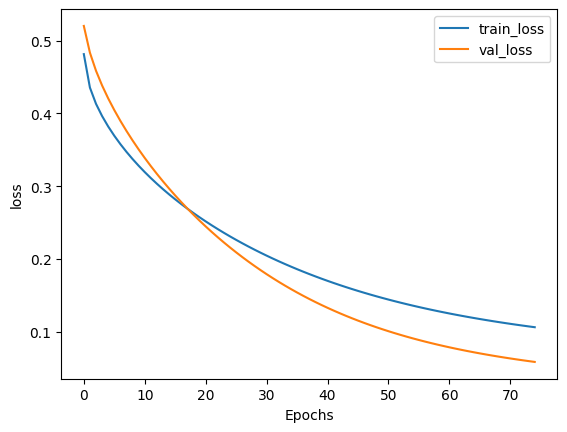

In [21]:
plot_history(history,'loss')

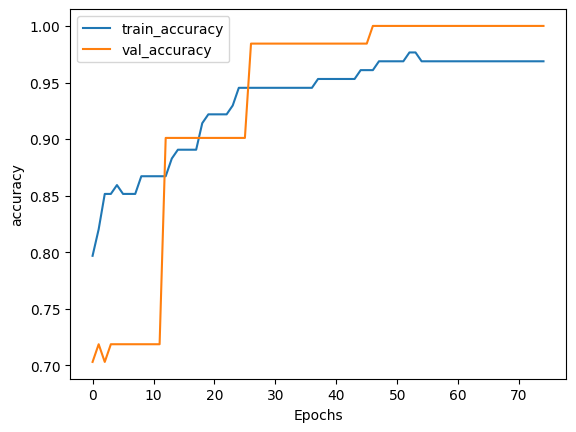

In [22]:
plot_history(history,'accuracy')